# Motion planning by learning the solution manifold in trajectory optimization
by Takayuki Osa


In [1]:
# !pip install matplotlib numpy

#### Hyperparamters

In [2]:
alpha = 10

#### Problem Formulation

In [3]:
# from mpl_toolkits.mplot3d import Axes3D  # Not needed with Matplotlib 3.6.3
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(42)

def shaping_func(r):
    r_max = np.max(r)
    r_med = np.median(r)
    return np.exp(alpha*(r - r_max)/(r_max - r_med)) if (r >= r_med).any() else 0
    # return np.exp(alpha*(r - r_max)/(r_max - r_med)) if np.greater_equal(r, r_med).any() else 0

def shaping_func_lsmo(r):
    return np.exp(alpha*(r))

#### Functions
The paper plots four (4) non-convex equations. The figure plots the range x<sub>1</sub> &in; [0, 2] and x<sub>2</sub> &in; [0, 2].

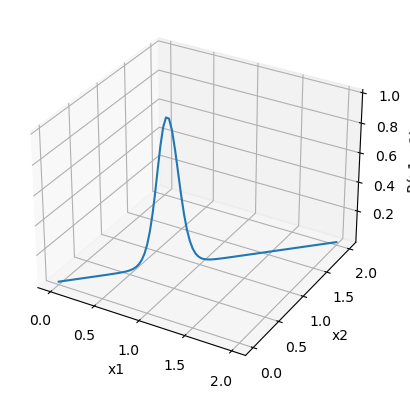

In [4]:
fig = plt.figure(figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')

x1 = np.linspace(0, 2, 100)
x2 = np.linspace(0, 2, 100)

def d(eq):
    return np.exp(-2*eq)

def r1(x1, x2):
    if np.less(x1, 0.5).any():
        return d(((x2 - 1.05)**2 + (x1 - 0.5)**2)**0.5)        
    elif np.greater_equal(x1, 1.5).any():
        return d(((x2 - 0.75)**2 + (x1 - 1.5)**2)**0.5)
    else:
        return d(abs(-0.3*x1 - x2 + 1.2) / 1.09**2)

def r2(x1, x2):
    return d(abs((x2 - 1.5)**2 + (x1 + 1)**2 - 2.5))

# print (np.greater_equal(x1, 1.4))

def r3(x1, x2):
    if np.less(x1, 0.7).any():
        return d(((x2 - 0.94)**2 + (x1 - 0.7)**2)**0.5 + 0.2*x2 + 0.14)
    elif np.greater_equal(x1, 1.4).any():
        return d(((x2 - 1.08)**2 + (x1 - 1.4)**2)**0.5 + 0.2*x2 + 0.14)
    else:
        return d((abs(0.2*x1 - x2 + 0.8)/1.04**2) + 0.2*x2 + 0.14)

def r4(x1, x2):
    return d(abs((x2 - 1)**2 + (x1 - 1)**2 - 0.5))

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('R(x1, x2)')

# ax.plot_surface(x1, x2, r1(x1, x2))
plt.plot(x1, x2, shaping_func(r1(x1, x2)))
# plt.plot(x1, x2, shaping_func(r2(x1, x2)))
# plt.plot(x1, x2, shaping_func(r3(x1, x2)))
# plt.plot(x1, x2, shaping_func(r4(x1, x2)))

# # Uncommnet for top view
# ax.elev = 90
# ax.azim = 90

# plt.show()

#### Algorithm 1. Abstract of Learning the Solution Manifold in Optimization (LSMO)
Input:  Objective function R(x), proposal distribution p<sup>prop</sup>(x), shaping function f\
Output: x*

##### Traning phase
1. Generate N synthetic samples {x<sub>i</sub>}<sup>N</sup><sub>i=1</sub> from the proposal distribution p<sup>prop</sup>(x)
2. Evaluate the objective function R(x<sub>i</sub>) and compute the weight f(R(x<sub>i</sub>)) for i = 1,...,N
3. Train p<sub>&theta;</sub>(x|z) by maximizing $\mathcal{L}$(**&theta;**|**&Psi;**) in Eq. (12)
##### Generation phase
4. Generate x<sup>*</sup> with p<sub>&theta;</sub>(x|z) by specifying the value of z
5. (Optional) Fine-tune x<sup>*</sup> with a gradient-based method

Return: x<sup>*</sup>

##### Step 1: Generate N synthetic samples {x<sub>i</sub>}<sup>N</sup><sub>i=1</sub> from the proposal distribution p<sup>prop</sup>(x)

x1:  [0.90859113 1.07080871 1.64725396 1.89485995 0.10551483 0.08212904
 1.09159106 0.93973243 0.04335563 0.9273639 ] 
x2:  [1.92337698 1.09100484 1.69560073 1.58271693 0.73605674 0.29605431
 1.50783026 0.74919884 0.69693583 0.93954718]


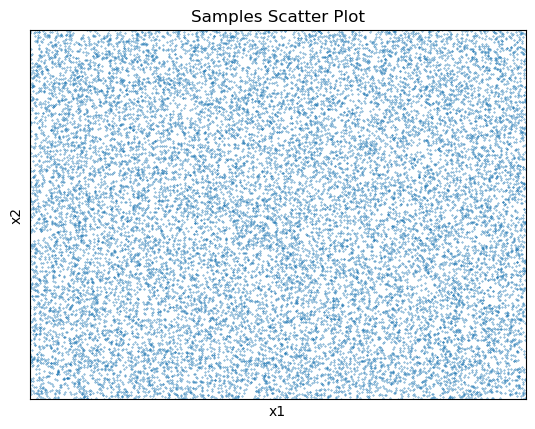

In [5]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.interpolate import griddata


num_samples = 20000

samples = np.random.uniform(0, 2, num_samples)
sample_x1 =samples[0:num_samples]
# sample_x2 =samples[num_samples::-1]
sample_x2 =np.random.uniform(0, 2, num_samples)

print("x1: ", sample_x1[0:10], "\nx2: ", sample_x2[0:10])

plt.scatter(sample_x1,sample_x2, s=0.1)
plt.title('Samples Scatter Plot')
plt.xlabel('x1')
plt.ylabel('x2')

plt.xticks([])  
plt.yticks([])

plt.xlim(0,2)
plt.ylim(0,2)

# Show the plot
plt.show()

##### Step 2: Evaluate the objective function R(x<sub>i</sub>) and compute the weight f(R(x<sub>i</sub>)) for i = 1,...,N

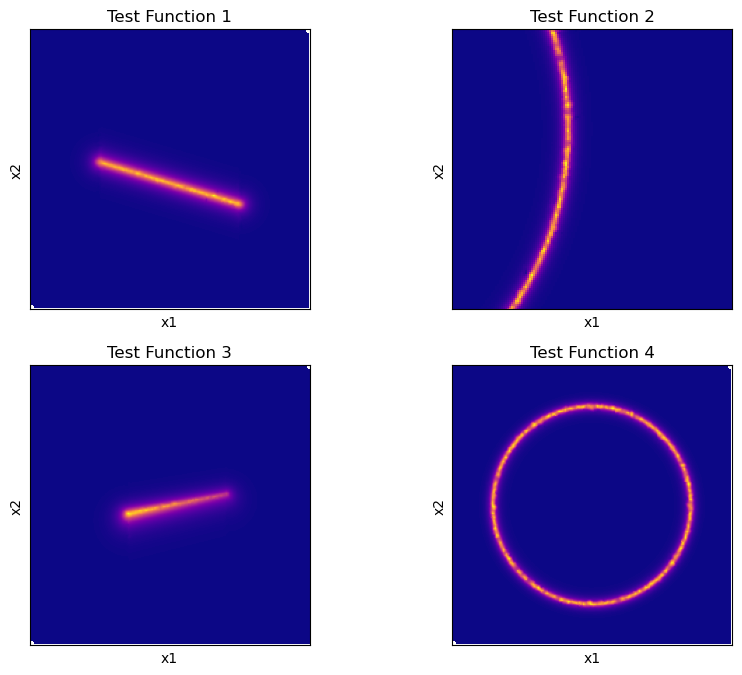

In [6]:
f1, f2, f3, f4 = [], [], [], []

x = sample_x1
y = sample_x2

for i in range(len(sample_x1)):
    r1_out = r1(sample_x1[i],sample_x2[i])
    f1.append(r1_out)
     
    r2_out = r2(sample_x1[i],sample_x2[i])
    f2.append(r2_out)
 
    r3_out = r3(sample_x1[i],sample_x2[i])
    f3.append(r3_out)
     
    r4_out = r4(sample_x1[i],sample_x2[i])
    f4.append(r4_out)

intensity1, intensity2, intensity3, intensity4 = shaping_func(f1), shaping_func(f2), shaping_func(f3),shaping_func(f4)  # Intensity values

# Define grid
grid_x, grid_y = np.mgrid[0:10:1000j, 0:10:1000j]

# Interpolate the intensity values on the grid
grid_z1 = griddata((x, y), intensity1, (grid_x, grid_y), method='cubic')
grid_z2 = griddata((x, y), intensity2, (grid_x, grid_y), method='cubic')
grid_z3 = griddata((x, y), intensity3, (grid_x, grid_y), method='cubic')
grid_z4 = griddata((x, y), intensity4, (grid_x, grid_y), method='cubic')

# Create a figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# Plot the density map
################################################################################# FUNTCION1
ax1.imshow(grid_z1.T, cmap='plasma')
# Add title and labels
ax1.set_title('Test Function 1')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
ax1.set_xticks([])  
ax1.set_yticks([])

ax1.set_xlim(0, 200)
ax1.set_ylim(0, 200)

################################################################################# FUNTCION2
ax2.imshow(grid_z2.T, cmap='plasma')
# Add title and labels
ax2.set_title('Test Function 2')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
ax2.set_xticks([])  
ax2.set_yticks([])

ax2.set_xlim(0, 140)
ax2.set_ylim(60, 200)

################################################################################# FUNTCION3
ax3.imshow(grid_z3.T, cmap='plasma')
# Add title and labels
ax3.set_title('Test Function 3')
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
ax3.set_xticks([])  
ax3.set_yticks([])

ax3.set_ylim(0, 200)
ax3.set_xlim(0, 200)

################################################################################# FUNTCION3
ax4.imshow(grid_z4.T, cmap='plasma')
# Add title and labels
plt.title('Test Function 4')
plt.xlabel('x1')
plt.ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
plt.xticks([])  
plt.yticks([])
# plt.colorbar(label='Intensity')

ax4.set_ylim(0, 200)
ax4.set_xlim(0, 200)

# Show the plot
plt.show()


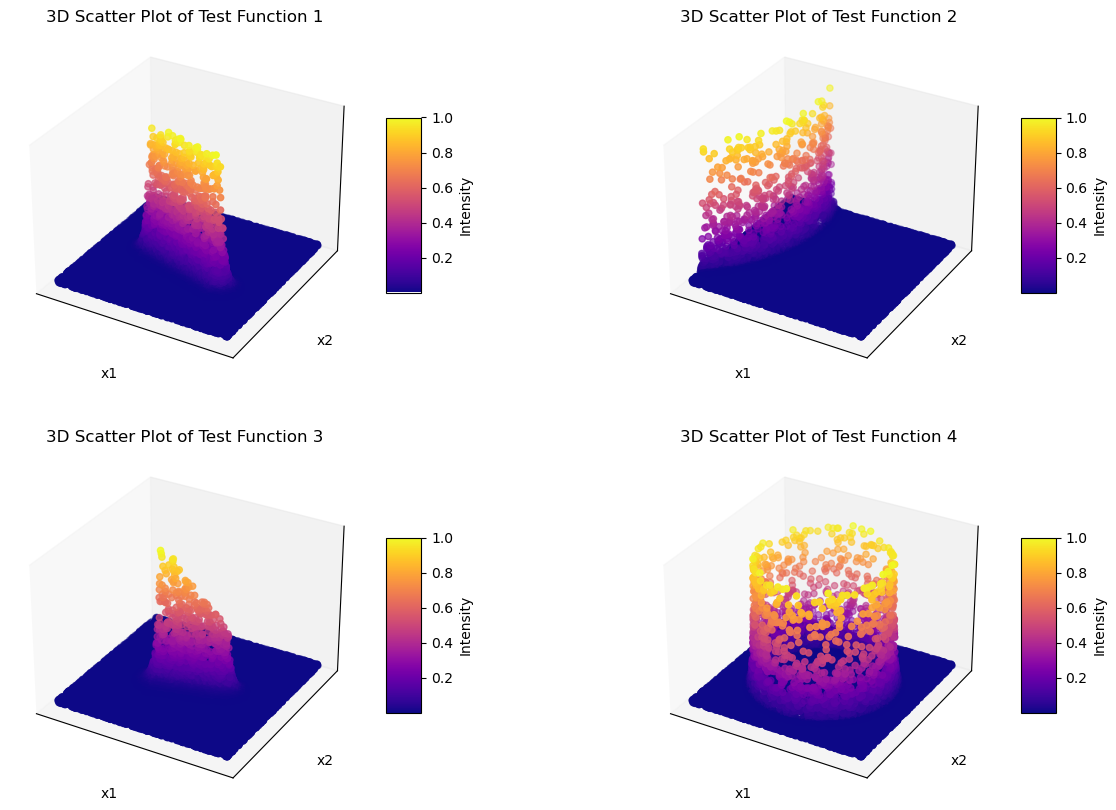

Argmax: 1.0


In [7]:
from mpl_toolkits.mplot3d import Axes3D

dataset = [intensity1, intensity2, intensity3, intensity4]
# Create a figure and a 3D subplot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
fig, axes = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': '3d'})
colormaps = ['plasma', 'plasma', 'plasma', 'plasma']

for i, (ax, data, cmap) in enumerate(zip(axes.flat, dataset, colormaps), start=1):

    sc = ax.scatter(sample_x1, sample_x2, data, c=data, cmap=cmap, marker='o')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Intensity')
    ax.set_title(f'3D Scatter Plot of Test Function {i}')
    cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Intensity')

    ax.set_xticks([])  
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(False)
    
    # ax.elev = 90
    # ax.azim = -90
# # Plot the data with an intensity map
# sc = ax.scatter(sample_x1, sample_x2, intensity4, c=intensity4, cmap='plasma', s=0.5)

# # Add a color bar to show the intensity scale
# colorbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
# colorbar.set_label('Intensity')

# # Set labels for axes
# ax.set_xlabel('Sample X1')
# ax.set_ylabel('Sample X2')
# # ax.set_zlabel('Intensity 1')
# ax.grid(False)
# ax.set_xticks([])  
# ax.set_yticks([])
# ax.set_zticks([])
# # ax.set_facecolor('black')

# Show the plot
plt.show()

print (f"Argmax: {max(intensity4)}")

In [8]:

# # Plot the data with an intensity map
# sc = ax.scatter(sample_x1, sample_x2, intensity4, c=intensity4, cmap='plasma', s=0.5)

# # Add a color bar to show the intensity scale
# colorbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
# colorbar.set_label('Intensity')

# # Set labels for axes
# ax.set_xlabel('Sample X1')
# ax.set_ylabel('Sample X2')
# # ax.set_zlabel('Intensity 1')
# ax.grid(False)
# ax.set_xticks([])  
# ax.set_yticks([])
# ax.set_zticks([])
# # ax.set_facecolor('black')

# # Show the plot
# plt.show()

# print (f"Argmax: {max(intensity4)}")

In [9]:
## We assume the proposal distribution is uniform

# from scipy.integrate import quad

# partition_func, error = quad(shaping_func, -2, 2)
# p_target = np.divide(shaping_func_lsmo(f1_shape), partition_func)
# print (p_target)
# p_prop = np.random.normal(-2, 2, num_samples)
# weight = np.divide(p_target, p_prop)

# print(weight[:20])

##### Step 3: Train p<sub>&theta;</sub>(x|z) by maximizing $\mathcal{L}$(**&theta;**|**&Psi;**) in Eq. (12)

In [10]:
import torchvision
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, data_type='binary'):
        super(VAE, self).__init__()

        # Encoder: layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)

        # Decoder: layers
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc41 = nn.Linear(hidden_size, input_size)
        self.fc42 = nn.Linear(hidden_size, input_size)

        self.data_type = data_type

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mean, log_var = self.fc21(h1), self.fc22(h1)
        return mean, log_var
    
    @staticmethod
    def reparameterize(mean, log_var):
        mu, sigma = mean, torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        return z
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        if self.data_type == "real":
            mean, log_var = torch.sigmoid(self.fc41(h3)), self.fc42(h3)
            return mean, log_var
        else:
            logits = self.fc41(h3)
            probs = torch.sigmoid(logits)
            return probs
         
    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        return z_mean, z_logvar, self.decode(z)

/home/sara/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [11]:
import torch
import torchvision
from models import VAE
import os
from torchvision.utils import save_image
from tqdm.notebook import trange, tqdm
import math
import tensorflow as tf

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_samples = num_samples
coeff_cap = 0.1 # gamma
learning_rate = 0.001
num_epochs = 350
batch_size = 250
hidden_layers = 64
latent_size =1
# info_cap = np.linspace(0, 5, num_epochs)
info_cap = [0.0, 5.0, 350000, coeff_cap]

input = np.array([[x, y] for x, y in zip(sample_x1, sample_x2)])
input = torch.Tensor(input)
output = torch.Tensor(np.array(intensity4))
print(f"Shape: {input.shape} \nType: {type(input)}")
print (input[0])

train_size = int(0.8 * len(input))
test_size = len(input) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(input, [train_size, test_size])
output_dataset, _ = torch.utils.data.random_split(output, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=input.reshape(2,num_samples), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=input.reshape(2,num_samples), batch_size=batch_size, shuffle=False)
output_loader =  torch.utils.data.DataLoader(dataset=output.reshape(1,num_samples), batch_size=batch_size, shuffle=True)

counter = 0

# def compute_elbo(x, reconst_x, mean, log_var):
#     # ELBO(Evidence Lower Bound) is the objective of VAE, we train the model just to maximize the ELBO.
#     output = x[2]
#     x =  torch.sigmoid(x)
#     reconst_error = -torch.nn.functional.binary_cross_entropy(reconst_x, x, reduction='sum')
#     # see Appendix B from VAE paper: "Kingma and Welling. Auto-Encoding Variational Bayes. ICLR-2014."
#     # -KL[q(z|x)||p(z)] = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
#     print (x.shape)
#     elbo = (reconst_error - kl_divergence) / len(x)
#     return elbo

# Define the custom loss function
def compute_elbo(x, reconst_x, mean, log_var):

    x =  torch.sigmoid(x)

    # Reconstruction loss: assume Gaussian distribution
    reconstruction_loss = num_samples*(-torch.nn.functional.binary_cross_entropy(reconst_x, x, reduction='sum'))
    
    # KL divergence loss
    kl_loss = torch.mean( -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()))
    
    # Linearly increase capacity of continuous channels
    cont_min, cont_max, cont_num_iters, cont_gamma = info_cap

    # Increase continuous capacity without exceeding cont_max
    cont_cap_current = (cont_max - cont_min) * counter/ float(cont_num_iters) + cont_min
    cont_cap_current = min(cont_cap_current, cont_max)
    # Calculate continuous capacity loss
    cont_capacity_loss = cont_gamma * torch.abs(cont_cap_current - kl_loss)
    
    # Total loss
    total_loss = reconstruction_loss - cont_capacity_loss 
    print (total_loss.size)
    return (total_loss / num_samples)

data_type = 'binary'

model = VAE(num_samples, hidden_layers, latent_size).to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_elbo = []
test_elbo = []

for epoch in tqdm(range(1, num_epochs + 1)):
    for batch_idx, val in enumerate(train_loader):
        # forward pass
        batch_data = val.to('cpu')
        batch_mean, batch_logvar, reconst_batch = model(batch_data)
        aver_loss = output[counter] * compute_elbo(batch_data, reconst_batch, batch_mean, batch_logvar)
        # backprop and optimize
        optimizer.zero_grad()
        aver_loss.backward()
        optimizer.step()
        counter += 1
        if (batch_idx + 1) % 100 == 0:
            print('Epoch {}/{}, Batch {}/{}, Aver_Loss: {:.2f}'.format(
                epoch, num_epochs, batch_idx + 1, math.ceil(len(train_loader) / batch_size), aver_loss.item()))

        with torch.no_grad():
        # elbo_curve on training-set
            total_elbo = 0
            for batch_idx, batch_x in enumerate(train_loader):
                batch_data = batch_x.to('cpu')
                batch_mean, batch_logvar, reconst_batch = model(batch_data)
                total_elbo += output[counter] * compute_elbo(batch_data, reconst_batch, batch_mean, batch_logvar).item()
            aver_elbo = total_elbo / (batch_idx + 1)
            train_elbo.append(aver_elbo)
           
            # elbo_curve on test-set
            total_elbo = 0
            for batch_idx, batch_x in enumerate(test_loader):
                batch_data = batch_x.to('cpu')
                batch_mean, batch_logvar, reconst_batch = model(batch_data)
                total_elbo += output[counter] * compute_elbo(batch_data, reconst_batch, batch_mean, batch_logvar).item()
            aver_elbo = total_elbo / (batch_idx + 1)
            test_elbo.append(aver_elbo)

# Save the trained model's parameters
paras_dir = 'trained_parameters'
if not os.path.exists(paras_dir):
    os.makedirs(paras_dir)
torch.save(model.state_dict(), os.path.join(paras_dir, 'mnist_zdim{}.pkl'.format(latent_size)))

2024-07-17 14:01:42.888780: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 14:01:43.149483: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 14:01:43.732654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Shape: torch.Size([20000, 2]) 
Type: <class 'torch.Tensor'>
tensor([0.9086, 1.9234])


  0%|          | 0/350 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x7feeed384470>
<built-in method size of Tensor object at 0x7feeed385190>
<built-in method size of Tensor object at 0x7feeed385250>
<built-in method size of Tensor object at 0x7feeed3854f0>
<built-in method size of Tensor object at 0x7feeed384a10>
<built-in method size of Tensor object at 0x7feeed3851f0>
<built-in method size of Tensor object at 0x7feeed3852b0>
<built-in method size of Tensor object at 0x7feeed384e90>
<built-in method size of Tensor object at 0x7feeed384890>
<built-in method size of Tensor object at 0x7feeed384a10>
<built-in method size of Tensor object at 0x7feeed384410>
<built-in method size of Tensor object at 0x7feeed385370>
<built-in method size of Tensor object at 0x7feeed385010>
<built-in method size of Tensor object at 0x7feeed385070>
<built-in method size of Tensor object at 0x7feeed384470>
<built-in method size of Tensor object at 0x7feeed3850d0>
<built-in method size of Tensor object at 0x7feeed384410>
<built-in meth

VAE(
  (fc1): Linear(in_features=20000, out_features=64, bias=True)
  (fc21): Linear(in_features=64, out_features=1, bias=True)
  (fc22): Linear(in_features=64, out_features=1, bias=True)
  (fc3): Linear(in_features=1, out_features=64, bias=True)
  (fc41): Linear(in_features=64, out_features=20000, bias=True)
  (fc42): Linear(in_features=64, out_features=20000, bias=True)
)
20000


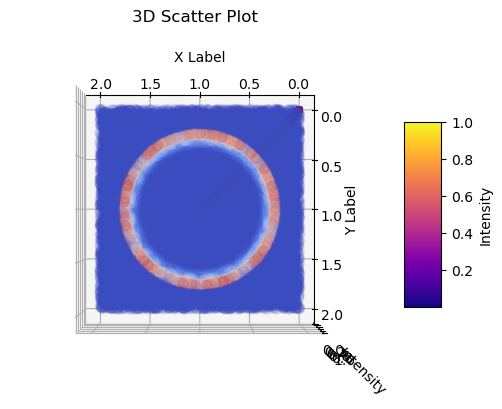

In [12]:
z_val = np.linspace(-1.64,1.64,num_samples)

def produce_z_values(num_samples):
    return np.linspace(-1.64, 1.64, num_samples)

# Build the model and recover the trained model parameters
model_2D = VAE(input_size=num_samples, hidden_size=hidden_layers, latent_size=latent_size).to('cpu')
model_2D.load_state_dict(torch.load(os.path.join(paras_dir, 'mnist_zdim1.pkl')))
print (model_2D)

# ========================= Experiment 1: Visualization of Learned MNIST Manifold ========================= #

# z_values = produce_z_values(100)
# z_values = torch.Tensor(z_values).float()

z_val = torch.Tensor(z_val.reshape(num_samples,1))

with torch.no_grad():

    generated_traj = model_2D.decode(z_val)#.view(-1,1,num_samples,num_samples)

# print(generated_traj)

x_array = generated_traj[:, 0].numpy()
y_array = generated_traj[:, 1].numpy()
z_array = generated_traj[:, 2].numpy()

print(len(x_array))

# print("X array:", x_array)
# print("Y array:", y_array)
# print("Z array:", z_array)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc1 = ax.scatter(x_array, y_array, z_array, c=z_array, cmap='Spectral', marker='o', label='generated')
sc2 = ax.scatter(sample_x1, sample_x2, intensity4, c=intensity4, cmap='coolwarm', marker='o', label='ground truth', alpha = 0.1, s = 50)

# Add a color bar to show the intensity scale
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Intensity')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Intensity')
ax.set_title('3D Scatter Plot')

# # Uncomment for top view
ax.elev = 90
ax.azim = 90

plt.show()


##### Step 4: Generate x<sup>*</sup> with p<sub>&theta;</sub>(x|z) by specifying the value of z

##### Step 5: (Optional) Fine-tune x<sup>*</sup> with a gradient-based method

In [13]:
#TODO

#### Variational Autoencoder
